# Training a neural network

In this module, we train a neural network. First, we import some packages. We also specify whether we want to use a GPU or a CPU. It will use a GPU if available, and otherwise use a CPU.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import QuantLib as ql
import time

import matplotlib.pyplot as plt
from IPython import display
from scipy.optimize import minimize

import HestonUtils
from HestonNN import Net

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


We import the desired data here. Notably, new datasets can be generated from **Module 1-Data Generation** and imported here. The sample dataset below has 1 million points and may be too large for some computers.

In [2]:
data_name = 'NARROW'
x = np.load(f'data/Heston_params_{data_name}.npy')
y = np.load(f'data/Heston_target_{data_name}.npy')

We now split the data into 90% training, and 10% validation (we evaluate on testing sets in another module).

In [3]:
cutoff = len(y) - int(len(y) / 10)
train_x = torch.from_numpy(x[:cutoff]).float().reshape(-1,9).to(device)
train_y = torch.from_numpy(y[:cutoff]).float().reshape(-1,1).to(device)
test_x = torch.from_numpy(x[cutoff:]).float().reshape(-1,9).to(device)
test_y = torch.from_numpy(y[cutoff:]).float().reshape(-1,1).to(device)

print(train_x[:5])
print(train_y[:5])

tensor([[ 1.2716e+00,  2.8767e-01,  3.5936e-01,  2.9683e+00,  1.5375e-01,
          5.3258e-01, -6.1219e-01,  1.3260e-03,  3.5469e-02],
        [ 8.0136e-01,  3.6164e-01,  1.0543e-02,  2.8071e+00,  1.2076e-01,
          1.2786e-01, -7.4558e-01,  2.9647e-02,  2.8829e-02],
        [ 1.2727e+00,  1.9644e+00,  3.6180e-03,  6.5907e-01,  1.4786e-01,
          3.5883e-01, -5.0067e-02,  4.4480e-02,  1.7024e-02],
        [ 6.5293e-01,  9.3699e-01,  5.9235e-02,  2.1551e+00,  8.7362e-02,
          1.3676e-01, -5.9714e-01,  7.0423e-03,  4.4361e-02],
        [ 1.0786e+00,  1.4658e+00,  3.3517e-01,  1.4201e+00,  2.2559e-01,
          4.9715e-01, -6.9635e-01,  2.3201e-02,  3.4334e-02]], device='cuda:0')
tensor([[0.3017],
        [0.0019],
        [0.3586],
        [0.0023],
        [0.2672]], device='cuda:0')


We will usually track all of our model runs, for comparison purposes. The below line of code is for organizational purposes, say if you'd like all ELU models labeled in the 1000s and all Softplus models labeled in the 2000s.

In [5]:
# np.save('run.npy', 0)

The function `trainNet` trains a given neural network on a given dataset.

In [4]:
def trainNet(net, train_x, train_y, test_x, test_y, 
            optimizer, loss_func, N_EPOCHS, SIZE_BATCH,
            save_fig = True):
    '''
    net: our desired neural network model
    train_x: our training input
    train_y: our training output
    test_x: our testing input
    test_x: our testing output
    optimizer: our choice of optimizer (see torch.optim for list of optimizers)
    loss_func: our choice of loss function (this will usually be the MSE loss; see torch.nn for list of other loss functions)
    N_EPOCHS: number of epochs to train over
    SIZE_BATCH: size of each minibatch
    save_fig: True if we want to save the model, false otherwise
    '''
    
    # calculates number of minibatches
    N = len(train_y)
    N_BATCHES = int(np.ceil(N / SIZE_BATCH))
    
    # keeps track of the run number
    if save_fig == True:
        RUN = np.load('run.npy') + 1
        np.save('run.npy', RUN)
    
    # keep track of training and validation losses
    train_losses = []
    test_losses = []
    time_start = time.time()
    
    # minibatch gradient descent
    for EPOCH in range(N_EPOCHS):
        indices = np.random.permutation(N)
        batches = [indices[i*SIZE_BATCH:(i+1)*SIZE_BATCH] for i in range(N_BATCHES)]
        for batch in batches:
            output = net(train_x[batch])
            train_loss = loss_func(output, train_y[batch])
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
        # decrease learning rate at the 2500th epoch
        if EPOCH == 2500:
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
        print(EPOCH)
        
        # calculate training and testing losses (note training losses are on a subset of the training set if size > 100000)
        with torch.no_grad():
            train_loss = loss_func(net(train_x[:100000]), train_y[:100000]).detach().to('cpu').numpy()
            test_loss = loss_func(net(test_x), test_y).detach().to('cpu').numpy()
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        # plot learning curve after each epoch
        if EPOCH % 1 == 0:
            f = plt.figure(figsize=(10,10),facecolor='w')
            ax1 = f.add_subplot(311)
            ax1.semilogy(train_losses)
            ax1.set_title(f'{train_loss}')
            
            ax2 = f.add_subplot(312)
            ax2.semilogy(test_losses)
            ax2.set_title(f'{test_loss}')
            
            text1 = str(net)
            text2 = f'Epoch: {EPOCH} \n Batch size: {SIZE_BATCH} \n Time Elapsed: {time.time() - time_start} \n Best: {min(test_losses)}'
            text3 = str(optimizer)
            text4 = data_name
            ax3 = f.add_subplot(313)
            ax3.text(0, 1, s=text1, va='top', ha='left')
            ax3.text(1, 1, s=text2, va='top', ha='right')
            ax3.text(1, 0, s=text3, va='bottom', ha='right')
            ax3.text(0, 0, s=text4, va='bottom', ha='left')
            ax3.get_xaxis().set_visible(False)
            ax3.get_yaxis().set_visible(False)
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax3.spines['left'].set_visible(False)
            
            # save the model with updated parameters, a plot of the learning curve, validation losses, and training losses
            if save_fig == True:
                plt.savefig(f'results/run_{RUN}')
                torch.save(net, f'models/run_{RUN}')
                np.save(f'losses/run_{RUN}.npy', np.array(test_losses))
                np.save(f'train_losses/run_{RUN}.npy', np.array(train_losses))
            
            display.display(f)
            display.clear_output(wait=True)
            plt.close(f)   

Below is an example of training a neural network. We specify the loss function as MSE, the activation function as the Softplus function, and the optimizer as the Adam optimizer (with step size $0.001$). For brevity we only train over 2000 epochs.

1999


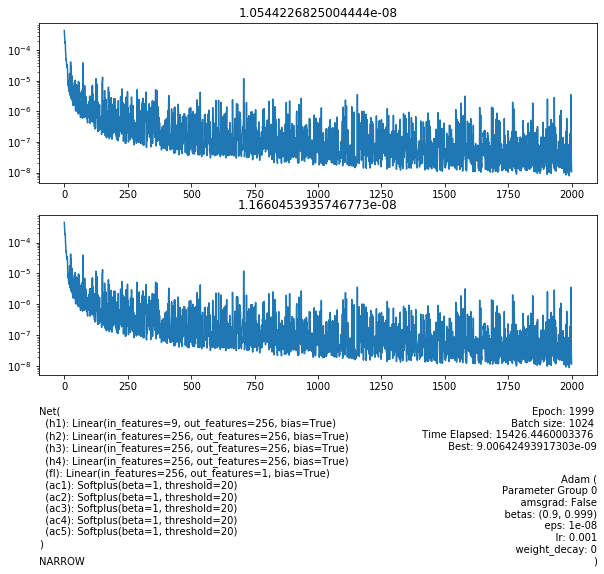

In [5]:
loss_func = torch.nn.MSELoss()
ac_fun = 'Softplus'
net = Net(n_input=9, n_hidden=256, n_output=1, ac_fun=ac_fun).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
trainNet(net, train_x, train_y, test_x, test_y,
         optimizer, loss_func, N_EPOCHS=2000, SIZE_BATCH=1024,
         save_fig = False)

One somewhat useful thing we can do is load previously trained networks and continue training with them. One caveat to this is that the optimizer is reset, and thus this is only useful in certain cases (i.e. when the optimizer does not require past gradients).

In [ ]:
loss_func = torch.nn.MSELoss()
ac_fun = 'Softplus'
# here we load a previously trained network, as an example
net = torch.load('models/run_65')
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
trainNet(net, train_x, train_y, test_x, test_y,
         optimizer, loss_func, N_EPOCHS=2000, SIZE_BATCH=1024,
         save_fig = False)